In [1]:
import sys
sys.path.append('..')

from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from tracks_interactions.db.db_model import TrackDB
import pandas as pd
import networkx as nx
import numpy as np

In [2]:
new_db_path = r'D:\test_data\Exp6_gardener_v6.db'

engine = create_engine(f'sqlite:///{new_db_path}')
session = sessionmaker(bind=engine)()

In [3]:
def render_tree_view(self, G, pos):
    """
    Render the hierarchical tree using NetworkX and PyQtGraph.
    """
    y_max = 1

    # Iterate over nodes in the graph
    for node in G.nodes():
        if G.in_degree(node) == 0:  # Skip root for now
            continue

        node_data = G.nodes[node]
        node_name = node_data['name']

        # Get position in time
        x1 = node_data['start']
        x2 = node_data['stop']
        x_signal = [x1, x2]

        # Get y coordinate from the NetworkX position dictionary
        y_signal = np.array([pos[node][1]]).repeat(2)
        y_max = np.max([y_signal[0], y_max])

        label_color = self.labels.get_color(node_name)

        # Pen color and style adjustments based on the node's state
        if node_name == self.active_label:
            pen_color = mkColor((label_color * 255).astype(int))
            pen = mkPen(color=pen_color, width=4)
        else:
            label_color[-1] = 0.4
            pen_color = mkColor((label_color * 255).astype(int))
            pen = mkPen(color=pen_color, width=2)

        if not node_data['accepted']:
            pen.setStyle(Qt.DotLine)

        # Plot the horizontal line for the node
        self.plot_view.plot(x_signal, y_signal, pen=pen)

        # Add text label for the node
        if node_data['accepted']:
            text_item = TextItem(str(node_name), anchor=(1, 1), color='green')
        else:
            text_item = TextItem(str(node_name), anchor=(1, 1))

        text_item.setPos(x2, pos[node][1])
        self.plot_view.addItem(text_item)

        # Plot vertical lines to children
        for child in G.successors(node):
            x_signal = [x2, x2]
            y_signal = [pos[node][1], pos[child][1]]
            self.plot_view.plot(x_signal, y_signal, pen=pen)

    # Set plot axis limits
    self.plot_view.setXRange(0, self.t_max)
    self.plot_view.setYRange(0, 1.1 * y_max)


def _add_children(G, parent, df, n=2):
    """
    Recursively adds children to the NetworkX graph from a dataframe.
    
    G - NetworkX graph
    parent - parent node ID
    df - dataframe with information about children
    n - counter for numbering nodes
    """
    children = df[df['parent_track_id'] == parent]

    for _, row in children.iterrows():
        child_id = row['track_id']
        G.add_node(child_id, name=row['track_id'], start=row['t_begin'], stop=row['t_end'], accepted=row['accepted_tag'], num=n)
        G.add_edge(parent, child_id)

        n += 1
        n = _add_children(G, child_id, df, n)

    return n

def build_Newick_tree(session, root_id):
    """
    Build a NetworkX graph to represent the hierarchical tree structure.
    
    session - database session
    root_id - ID of the root node
    """
    # Get info about the family from the database
    query = session.query(TrackDB).filter(TrackDB.root == root_id)
    df = pd.read_sql(query.statement, session.bind)

    # Ensure the root exists
    assert len(df) > 0, 'No data for this root_id'

    # Create a NetworkX graph
    G = nx.DiGraph()

    # Add the root (trunk) node
    trunk_row = df[df['track_id'] == root_id]
    G.add_node(root_id, name=root_id, start=trunk_row['t_begin'].values[0], stop=trunk_row['t_end'].values[0], accepted=bool(trunk_row['accepted_tag'].values[0]), num=1)

    # Recursively add children
    _add_children(G, root_id, df)

    # add rendering
    pos = nx.spring_layout(G, seed=42)
    nx.set_node_attributes(G, pos, 'pos')


    # Return the NetworkX graph
    return G

In [46]:
G = build_Newick_tree(session,23330)

In [47]:
def reingold_tilford(tree, node=None, depth=0, x_offset=0, x_spacing=1):
    """
    Recursive function to apply Reingold-Tilford algorithm for binary trees.
    
    Args:
        tree: NetworkX DiGraph representing the tree.
        node: Current node being processed (if None, starts at the root).
        depth: Current depth level in the tree.
        x_offset: Horizontal position offset for the current node.
        x_spacing: Spacing between nodes.
    
    Returns:
        pos: Dictionary of node positions with x, y coordinates.
    """
    # If no node is specified, start from the root node (node with in-degree 0)
    if node is None:
        node = next(n for n in tree.nodes() if tree.in_degree(n) == 0)

    if tree.out_degree(node) == 0:  # If leaf node
        return {node: (x_offset, -depth)}
    
    children = list(tree.successors(node))
    
    # Get positions of left and right subtrees
    pos_left = reingold_tilford(tree, children[0], depth+1, x_offset, x_spacing) if len(children) > 0 else {}
    pos_right = reingold_tilford(tree, children[1], depth+1, x_offset + len(pos_left) * x_spacing, x_spacing) if len(children) > 1 else {}
    
    # Calculate the center x position of the current node
    num_left = len(pos_left)
    num_right = len(pos_right)
    
    # Center node between left and right children
    x_center = x_offset + (num_left + num_right - 1) / 2.0 * x_spacing
    pos = {node: (x_center, -depth)}
    
    # Merge positions of subtrees
    pos.update(pos_left)
    pos.update(pos_right)
    
    return pos


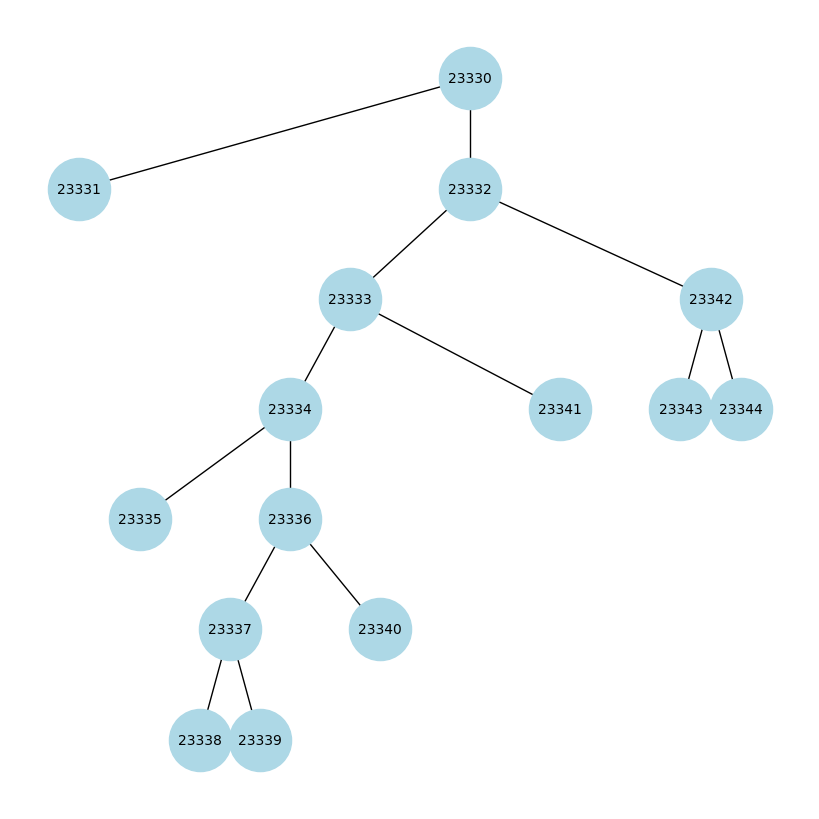

In [48]:
# Apply Reingold-Tilford algorithm for positioning
pos = reingold_tilford(G)

# Draw the tree
plt.figure(figsize=(8, 8))
nx.draw(G, pos=pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, arrows=False)
plt.show()

In [49]:
pos

{23330: (6.5, 0),
 23331: (0, -1),
 23332: (6.5, -1),
 23333: (4.5, -2),
 23334: (3.5, -3),
 23335: (1, -4),
 23336: (3.5, -4),
 23337: (2.5, -5),
 23338: (2, -6),
 23339: (3, -6),
 23340: (5, -5),
 23341: (8, -3),
 23342: (10.5, -2),
 23343: (10, -3),
 23344: (11, -3)}

In [50]:
y_values = {node: x for node, (x, y) in pos.items()}
nx.set_node_attributes(G, y_values, 'y')

In [26]:
for node in G.nodes():

    node_data = G.nodes[node]
    node_name = node_data['name']

    # Get position in time (x-coordinates: start and stop)
    x1 = node_data['start']
    x2 = node_data['stop']
    x_signal = [x1, x2]

    # Get y-coordinate from the node's 'pos' attribute
    y_signal = np.array([node_data['pos'][1]]).repeat(2)
    print(node_name, x_signal, y_signal)

21274 [0, 39] [-0.1999618 -0.1999618]
21275 [40, 155] [-0.69401799 -0.69401799]
21276 [40, 97] [0.30172145 0.30172145]
21277 [98, 99] [0.10866962 0.10866962]
21278 [98, 217] [0.48358871 0.48358871]
